In [1]:
import os,sys,time
from loguru import logger 

import scimap as sm

import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import anndata as ad

import pyarrow
import ast

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#custom functions
sys.path.append(os.path.abspath('/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/'))
import opendvp.anndata_utils
import opendvp.filtering
import importlib

for package in [np,pd,gpd,ad,sm]:
    print(f"{package.__name__} {package.__version__}")

Running SCIMAP  2.2.11
numpy 1.26.4
pandas 2.2.3
geopandas 1.0.1
anndata 0.10.9
scimap 2.2.11


In [2]:
def get_datetime():
    return time.strftime("%Y%m%d_%H%M")
get_datetime()

'20250302_1748'

In [3]:
def save_adata_checkpoint(adata, path_to_dir, checkpoint_name):
    try:    
        os.makedirs(path_to_dir, exist_ok=True)
        os.makedirs(os.path.join(path_to_dir,checkpoint_name), exist_ok=True)
        basename = f"{os.path.join(path_to_dir,checkpoint_name)}/{get_datetime()}_{checkpoint_name}_adata"
        
        # Save h5ad file
        try:
            logger.info("Writing h5ad")
            adata.write_h5ad(filename = basename + ".h5ad")
            logger.success("Wrote h5ad file")
        except (OSError, IOError, ValueError) as e:
                logger.error(f"Could not write h5ad file: {e}")
                return
        
        # Save CSV file
        try:
            logger.info("Writing parquet")
            adata.to_df().to_parquet(path=basename + ".parquet")
            logger.success("Wrote parquet file")
        except (OSError, IOError, ValueError) as e:
            logger.error(f"Could not write parquet file: {e}")

    except Exception as e:
        logger.error(f"Unexpected error in save_adata_checkpoint: {e}")

In [4]:
!pixi list

Package                           Version         Build                 Size        Kind   Source
anndata                           0.10.9                                424 KiB     pypi   anndata-0.10.9-py3-none-any.whl
anyio                             4.8.0           pyhd8ed1ab_0          112.6 KiB   conda  anyio
aom                               3.9.1           h7bae524_0            2.1 MiB     conda  aom
appnope                           0.1.4           pyhd8ed1ab_1          9.8 KiB     conda  appnope
argon2-cffi                       23.1.0          pyhd8ed1ab_1          18.2 KiB    conda  argon2-cffi
argon2-cffi-bindings              21.2.0          py311h460d6c5_5       32.2 KiB    conda  argon2-cffi-bindings
array_api_compat                  1.11                                  172.4 KiB   pypi   array_api_compat-1.11-py3-none-any.whl
arrow                             1.3.0           pyhd8ed1ab_1          97.6 KiB    conda  arrow
asciitree                         0.3.3       

# Step 0: load data

In [23]:
sample_id = 991
path_to_quant = f"/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/quantification/991.csv"
path_to_artefact_annotations = f"/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/geojsons/QuPath_annotations_for_analysis/991.geojson"
path_to_gates = "/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/phenotyping/gates/20240918_gates.csv"
path_to_phenotype_matrix = "/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/phenotyping/phenotype_matrix/20240905_PhenotypeMatrix_v3.csv"

In [24]:
#backup those files for replication
path_to_backup = "/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/991/input_files/"
os.makedirs(path_to_backup, exist_ok=True)

import shutil
for path in  [path_to_quant, path_to_artefact_annotations, path_to_gates, path_to_phenotype_matrix]:
    logger.info(f"Backing up {path} to {path_to_backup}")
    shutil.copy2(path, os.path.join(path_to_backup, os.path.basename(path)) )

2025-03-02 12:02:24.466 | INFO     | __main__:<module>:7 - Backing up /Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/quantification/991.csv to /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/991/input_files/
2025-03-02 12:02:26.244 | INFO     | __main__:<module>:7 - Backing up /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/geojsons/QuPath_annotations_for_analysis/991.geojson to /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/991/input_files/
2025-03-02 12:02:26.248 | INFO     | __main__:<module>:7 - Backing up /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/phenotyping/gates/20240918_gates.csv to /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/991/input_files/
2025-03-02 12:02:26.249 | INFO     | __main__:<module>:7 - Backing up /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/phenotyping/phenotype_m

In [5]:
#new paths
path_to_quant = "../data/perSample/991/input_files/991.csv"
path_to_artefact_annotations = "../data/perSample/991/input_files/991.geojson"
path_to_phenotype_matrix = "../data/perSample/991/phenotyping/20240905_PhenotypeMatrix_v3.csv"
path_to_gates = "../data/perSample/991/phenotyping/20241002_1135_gates_CD8_1600.csv"
path_to_backup = "../data/perSample/991/adata_checkpoints/"

# Step 1: Filtering for artefacts

In [6]:
adata = opendvp.anndata_utils.read_quant(path_to_quant)

2025-03-02 17:48:53.197 | INFO     | opendvp.anndata_utils:read_quant:16 -  ---- read_quant : version number 1.1.0 ----
2025-03-02 17:48:56.840 | INFO     | opendvp.anndata_utils:read_quant:36 -  685805 cells and 75 variables
2025-03-02 17:48:56.841 | INFO     | opendvp.anndata_utils:read_quant:37 -  ---- read_quant is done, took 3s  ----


In [9]:
adata.obs.index = adata.obs.index.astype(int) + 1
adata.obs['CellID'] = adata.obs['CellID'] + 1
adata.obs 

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity
1,1,29410.806452,35874.857801,1519.0,98.696620,30.646839,0.950568,-1.524977,228.651804,0.676615
2,2,29445.080408,36162.243140,1567.0,50.422862,39.687556,0.616832,0.160002,148.710678,0.975109
3,3,29505.171707,38455.235122,1025.0,40.280587,34.195207,0.528513,-0.346644,131.438600,0.927602
4,4,29539.721673,35060.844867,1315.0,61.049935,28.208869,0.886848,-1.447088,151.254834,0.947406
5,5,29982.642779,36765.660558,3656.0,84.178897,57.384893,0.731630,0.251203,243.379726,0.926743
...,...,...,...,...,...,...,...,...,...,...
685801,685801,40389.067593,46087.962963,1080.0,56.372404,25.352581,0.893163,1.002754,141.610173,0.961710
685802,685802,40382.629182,47716.017658,1076.0,41.856049,34.076776,0.580666,1.330143,129.396970,0.951370
685803,685803,40382.072917,48436.798177,768.0,33.256837,29.969709,0.433488,0.983058,105.254834,0.957606
685804,685804,40383.786948,45011.021113,1042.0,45.051210,31.924524,0.705583,1.218499,133.189863,0.964815


In [10]:
save_adata_checkpoint(adata=adata, path_to_dir="../data/perSample/991/adata_checkpoints/", checkpoint_name="0_init")

2025-03-02 17:51:41.081 | INFO     | __main__:save_adata_checkpoint:9 - Writing h5ad


2025-03-02 17:51:41.546 | SUCCESS  | __main__:save_adata_checkpoint:11 - Wrote h5ad file
2025-03-02 17:51:41.547 | INFO     | __main__:save_adata_checkpoint:18 - Writing parquet
2025-03-02 17:51:43.530 | SUCCESS  | __main__:save_adata_checkpoint:20 - Wrote parquet file


## Step 1.1 : Remove manually labelled artefacts

2025-03-02 17:51:47.851 | INFO     | opendvp.filtering:filter_by_annotation:144 -  ---- filter_by_annotation : version number 2.0.1 ----
2025-03-02 17:51:47.852 | INFO     | opendvp.filtering:filter_by_annotation:145 -  Each class of annotation will be a different column in adata.obs
2025-03-02 17:51:47.853 | INFO     | opendvp.filtering:filter_by_annotation:146 -  TRUE means cell was inside annotation, FALSE means cell not in annotation
2025-03-02 17:51:50.926 | INFO     | opendvp.filtering:filter_by_annotation:153 - GeoJson loaded, detected: 17 annotations


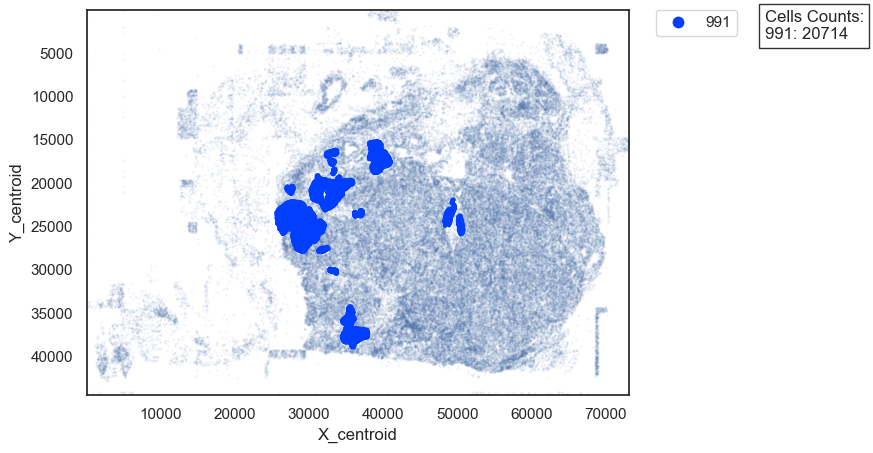

In [11]:
adata = opendvp.filtering.filter_by_annotation(adata, path_to_artefact_annotations)

In [12]:
save_adata_checkpoint(adata=adata, path_to_dir=path_to_backup, checkpoint_name="1_annotation_filter")

2025-03-02 17:51:58.474 | INFO     | __main__:save_adata_checkpoint:9 - Writing h5ad
2025-03-02 17:51:58.682 | SUCCESS  | __main__:save_adata_checkpoint:11 - Wrote h5ad file
2025-03-02 17:51:58.683 | INFO     | __main__:save_adata_checkpoint:18 - Writing parquet
2025-03-02 17:51:59.359 | SUCCESS  | __main__:save_adata_checkpoint:20 - Wrote parquet file


## Step 1.2: Remove 'cells' with too low DAPI

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log10



Threshold for DAPI intensity: 100.00
Threshold for DAPI intensity: 3162.28


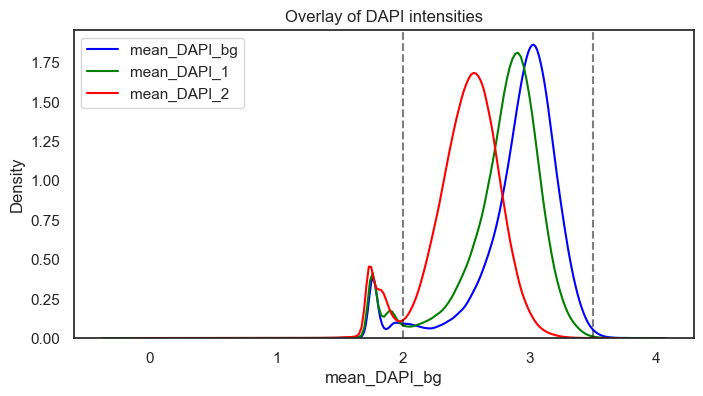

In [13]:
# Plot the density plot for each column
plt.figure(figsize=(8,4))
tmp_df = np.log10(pd.DataFrame(adata.X, columns=adata.var_names))
sns.kdeplot(tmp_df['mean_DAPI_bg'], label='mean_DAPI_bg', color='blue')
sns.kdeplot(tmp_df['mean_DAPI_1'], label='mean_DAPI_1', color='green')
sns.kdeplot(tmp_df['mean_DAPI_2'], label='mean_DAPI_2', color='red')

low_threshold = 2
plt.axvline(low_threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**low_threshold:.2f}")

high_threshold = 3.5
plt.axvline(high_threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**high_threshold:.2f}")

plt.title('Overlay of DAPI intensities')
plt.legend()
plt.show()

In [14]:
adata = opendvp.filtering.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=100, keep="above")
adata = opendvp.filtering.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=3162, keep="below")

2025-03-02 17:52:05.013 | INFO     | opendvp.filtering:filter_by_abs_value:39 -  ---- filter_by_abs_value : version number 1.1.0 ----
/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

2025-03-02 17:52:05.332 | INFO     | opendvp.filtering:filter_by_abs_value:73 - Number of cells with mean_DAPI_bg above 100: 653466
2025-03-02 17:52:05.332 | INFO     | opendvp.filtering:filter_by_abs_value:88 -  ---- filter_by_abs_value is done, took 0s  ----
2025-03-02 17:52:05.338 | INFO     | opendvp.filtering:filter_by_abs_value:39 -  ---- filter_by_abs_value : version number 1.1.0 ----
2025-03-02 17:52:05.426 | INFO     | opendvp.filtering:filter_by_abs_value:73 - Number of cells with mean_DAPI_bg below 3162: 683930
2025-03-02 17:52:05.426 | INFO     | opendvp.filtering:filter_by_abs_value:88 -  ---- filter_by_abs_value is done, took 0s  ----


In [15]:
save_adata_checkpoint(adata,path_to_dir=path_to_backup, checkpoint_name="2_abs_DAPI_filter")

2025-03-02 17:52:07.955 | INFO     | __main__:save_adata_checkpoint:9 - Writing h5ad
2025-03-02 17:52:08.213 | SUCCESS  | __main__:save_adata_checkpoint:11 - Wrote h5ad file
2025-03-02 17:52:08.214 | INFO     | __main__:save_adata_checkpoint:18 - Writing parquet
2025-03-02 17:52:09.032 | SUCCESS  | __main__:save_adata_checkpoint:20 - Wrote parquet file


## Step 1.3: Remove cells that are too small or too big

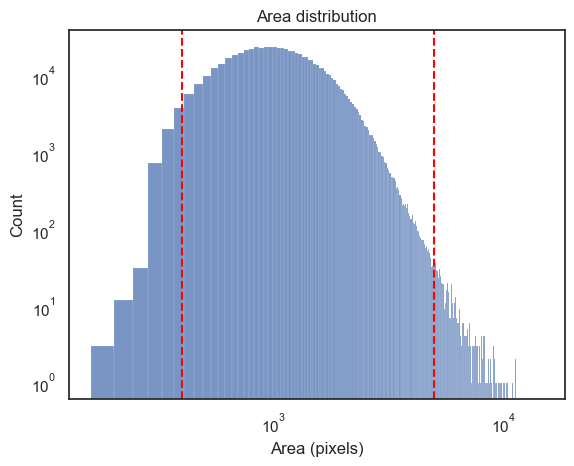

In [16]:
sns.histplot(adata.obs['Area'], bins=350)
plt.yscale('log')
plt.xscale('log')
plt.title('Area distribution')
plt.xlabel('Area (pixels)')
plt.axvline(400, color='red', linestyle='--')
plt.axvline(5000, color='red', linestyle='--')
plt.show()

In [17]:
adata.obs['Area_filter_nottoobig'] = adata.obs['Area'] < 5000
adata.obs['Area_filter_nottoolow'] = adata.obs['Area'] > 400
adata.obs['Area_filter'] = adata.obs['Area_filter_nottoobig'] & adata.obs['Area_filter_nottoolow']

In [18]:
save_adata_checkpoint(adata, path_to_dir=path_to_backup, checkpoint_name="3_area_filter")

2025-03-02 17:52:15.467 | INFO     | __main__:save_adata_checkpoint:9 - Writing h5ad
2025-03-02 17:52:15.731 | SUCCESS  | __main__:save_adata_checkpoint:11 - Wrote h5ad file
2025-03-02 17:52:15.731 | INFO     | __main__:save_adata_checkpoint:18 - Writing parquet
2025-03-02 17:52:16.516 | SUCCESS  | __main__:save_adata_checkpoint:20 - Wrote parquet file


## Step 1.4: Remove dropout cells by DAPI ratio 

2025-03-02 17:52:18.539 | INFO     | opendvp.filtering:filter_by_ratio:94 -  ---- filter_by_ratio : version number 1.1.0 ----
2025-03-02 17:52:18.650 | INFO     | opendvp.filtering:filter_by_ratio:112 - Number of cells with DAPI ratio < 0.15: 20618
2025-03-02 17:52:18.672 | INFO     | opendvp.filtering:filter_by_ratio:113 - Number of cells with DAPI ratio > 1.05: 5125
2025-03-02 17:52:18.694 | INFO     | opendvp.filtering:filter_by_ratio:114 - Number of cells with DAPI ratio between 0.15 and 1.05: 659829
2025-03-02 17:52:18.715 | INFO     | opendvp.filtering:filter_by_ratio:115 - Percentage of cells filtered out: 3.79%


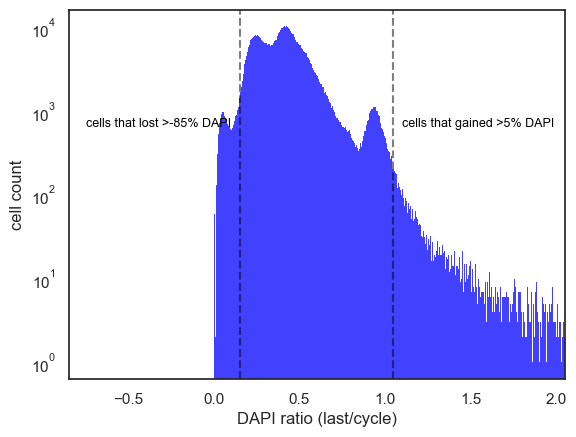

2025-03-02 17:52:20.590 | INFO     | opendvp.filtering:filter_by_ratio:135 -  ---- filter_by_ratio is done, took 2s  ----


In [19]:
adata = opendvp.filtering.filter_by_ratio(
    adata=adata, 
    end_cycle="mean_DAPI_2", 
    start_cycle="mean_DAPI_bg", 
    label="DAPI",
    min_ratio=0.15,
    max_ratio=1.05,
    )

In [20]:
save_adata_checkpoint(adata,path_to_dir=path_to_backup,checkpoint_name="4_dropout_cells_filter")

2025-03-02 17:52:21.458 | INFO     | __main__:save_adata_checkpoint:9 - Writing h5ad
2025-03-02 17:52:21.694 | SUCCESS  | __main__:save_adata_checkpoint:11 - Wrote h5ad file
2025-03-02 17:52:21.695 | INFO     | __main__:save_adata_checkpoint:18 - Writing parquet
2025-03-02 17:52:22.465 | SUCCESS  | __main__:save_adata_checkpoint:20 - Wrote parquet file


## Step 1.5: Quality control by plotting filtered cells

In [21]:
condition = (~adata.obs['artefact'].astype(bool) & 
            adata.obs['mean_DAPI_bg_above_100'] & 
            adata.obs['mean_DAPI_bg_below_3162'] & 
            adata.obs['Area_filter'] & 
            adata.obs['DAPI_ratio_pass'])

In [22]:
adata.obs['filtering'] = condition.values

In [23]:
print(adata.shape)
adata = adata[adata.obs['filtering']==True]
print(adata.shape)

(685805, 75)
(610182, 75)


In [24]:
save_adata_checkpoint(adata=adata, path_to_dir=path_to_backup, checkpoint_name="5_filtering_done")

2025-03-02 17:52:36.712 | INFO     | __main__:save_adata_checkpoint:9 - Writing h5ad
2025-03-02 17:52:37.080 | SUCCESS  | __main__:save_adata_checkpoint:11 - Wrote h5ad file
2025-03-02 17:52:37.081 | INFO     | __main__:save_adata_checkpoint:18 - Writing parquet
2025-03-02 17:52:37.911 | SUCCESS  | __main__:save_adata_checkpoint:20 - Wrote parquet file


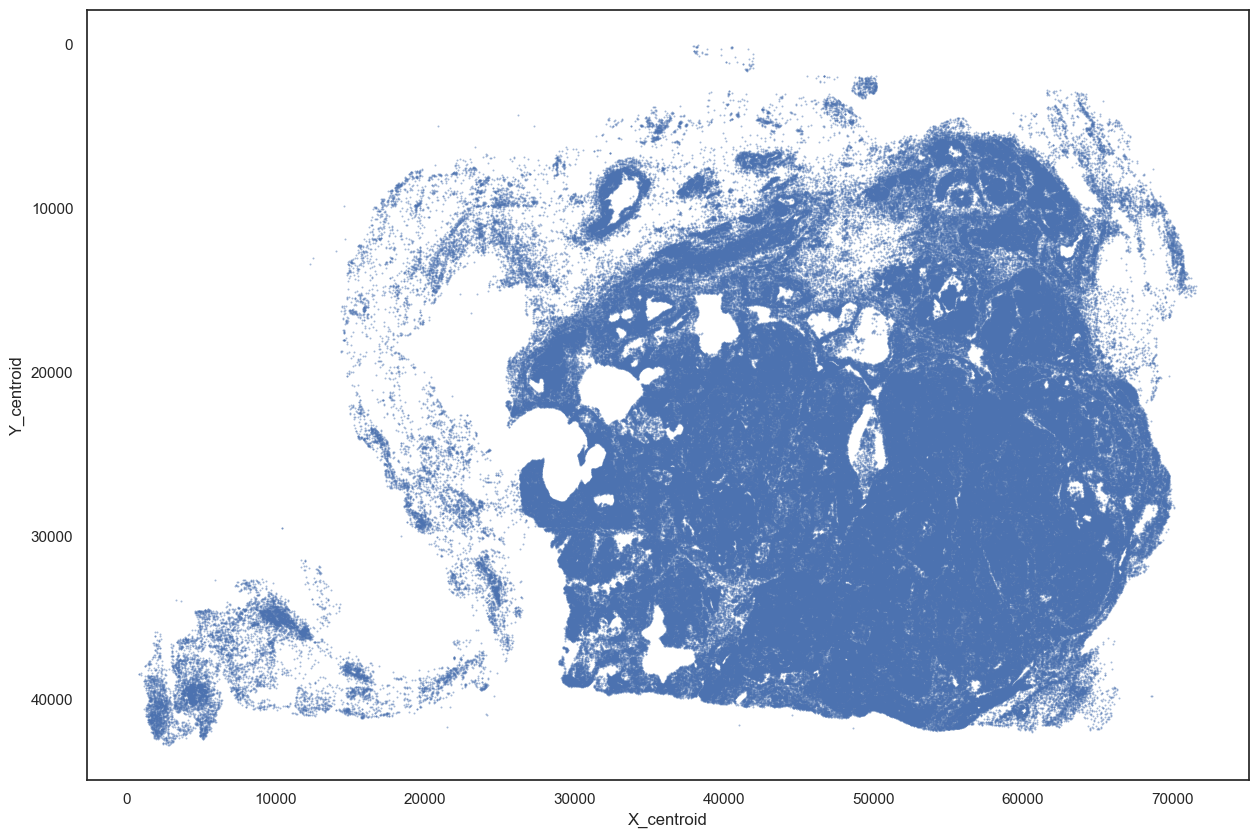

In [25]:
sns.scatterplot(data=adata.obs, x='X_centroid', y='Y_centroid', linewidth=0, s=2, alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(15, 10)
#flip y axis
plt.gca().invert_yaxis()
plt.show()

# Step 2: Phenotyping

In [26]:
import opendvp.phenotyping

In [27]:
gates = opendvp.phenotyping.read_gates(path_to_gates, sample_id=991)

2025-03-02 17:52:45.257 | INFO     | opendvp.phenotyping:read_gates:12 -  ---- read_gates : version number 1.1.0 ----
2025-03-02 17:52:45.260 | INFO     | opendvp.phenotyping:read_gates:18 -    Filtering out all rows with value 0.0 (assuming not gated)
2025-03-02 17:52:45.261 | INFO     | opendvp.phenotyping:read_gates:21 -   Found 8 valid gates
2025-03-02 17:52:45.261 | INFO     | opendvp.phenotyping:read_gates:22 -   Markers found: ['mean_Vimentin' 'mean_CD3e' 'mean_panCK' 'mean_CD8' 'mean_COL1A1'
 'mean_CD20' 'mean_CD68' 'mean_Ki67']
2025-03-02 17:52:45.262 | INFO     | opendvp.phenotyping:read_gates:23 -   Samples found: [991]
2025-03-02 17:52:45.262 | INFO     | opendvp.phenotyping:read_gates:28 -   Found 8 valid gates for sample 991
2025-03-02 17:52:45.262 | INFO     | opendvp.phenotyping:read_gates:30 -  ---- read_gates is done, took 0s  ----


In [28]:
gates_processed = opendvp.phenotyping.process_gates_for_sm(gates, sample_id=991)

2025-03-02 17:52:46.982 | INFO     | opendvp.phenotyping:process_gates_for_sm:35 -  ---- process_gates_for_sm : version number 1.2.0 ----
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/opendvp/phenotyping.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-03-02 17:52:46.985 | INFO     | opendvp.phenotyping:process_gates_for_sm:44 -  ---- process_gates_for_sm is done, took 0s  ----


In [29]:
adata_pheno = adata[:, adata.var_names.isin(gates_processed['markers'])].copy()

In [30]:
adata_pheno.obs['imageid'] = 991

In [31]:
adata_pheno.raw = adata_pheno
sm.pp.log1p(adata_pheno)
adata_pheno = sm.pp.rescale(adata_pheno, gate=gates_processed, log=True, verbose=True)

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/scimap/preprocessing/rescale.py:145: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`




Scaling Image: 991
Scaling mean_Vimentin (gate: 6.355)
Scaling mean_CD3e (gate: 5.861)
Scaling mean_panCK (gate: 3.932)
Scaling mean_CD8 (gate: 7.378)
Scaling mean_COL1A1 (gate: 7.186)
Scaling mean_CD20 (gate: 6.686)
Scaling mean_CD68 (gate: 5.608)
Scaling mean_Ki67 (gate: 2.950)


In [32]:
sm.tl.phenotype_cells (adata_pheno, phenotype=pd.read_csv(path_to_phenotype_matrix), label="phenotype")

Phenotyping Cancer_cells
Phenotyping T_cells
Phenotyping Vimentin_cells
Phenotyping COL1A1_cells
Phenotyping B_cells
Phenotyping Macrophages
-- Subsetting T_cells
Phenotyping CD4_Tcells
Phenotyping CD8_Tcells
Consolidating the phenotypes across all groups


/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



AnnData object with n_obs × n_vars = 610182 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', '991', 'artefact', 'mean_DAPI_bg_above_100', 'mean_DAPI_bg_below_3162', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype'
    var: 'math', 'marker'
    uns: 'gates'
    layers: 'log'

In [33]:
adata.obs['phenotype'] = adata_pheno.obs['phenotype'].copy()
adata.obs['imageid'] = 991
adata.uns['gates'] = adata_pheno.uns['gates'].copy()
adata.uns['gates'].columns = [str(col) for col in adata.uns['gates'].columns]
adata.uns['X_log1p'] = adata_pheno.layers['log']
adata.uns['X_scaled_pheno'] = adata_pheno.X.copy()

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_33734/3601950691.py:1: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [52]:
adata_pheno.uns['gates'].columns = [str(col) for col in adata_pheno.uns['gates'].columns]

In [34]:
save_adata_checkpoint(adata=adata, path_to_dir=path_to_backup, checkpoint_name="6_phenotyped")

2025-03-02 17:53:19.122 | INFO     | __main__:save_adata_checkpoint:9 - Writing h5ad


2025-03-02 17:53:19.399 | SUCCESS  | __main__:save_adata_checkpoint:11 - Wrote h5ad file
2025-03-02 17:53:19.400 | INFO     | __main__:save_adata_checkpoint:18 - Writing parquet
2025-03-02 17:53:20.176 | SUCCESS  | __main__:save_adata_checkpoint:20 - Wrote parquet file


In [53]:
save_adata_checkpoint(adata=adata_pheno, path_to_dir=path_to_backup, checkpoint_name="7_adata_pheno")

2025-03-02 18:23:49.284 | INFO     | __main__:save_adata_checkpoint:9 - Writing h5ad
2025-03-02 18:23:49.508 | SUCCESS  | __main__:save_adata_checkpoint:11 - Wrote h5ad file
2025-03-02 18:23:49.509 | INFO     | __main__:save_adata_checkpoint:18 - Writing parquet
2025-03-02 18:23:49.699 | SUCCESS  | __main__:save_adata_checkpoint:20 - Wrote parquet file


# Step 3: Describe phenotyping

In [50]:
adata_pheno.obs

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,...,Area_filter_nottoobig,Area_filter_nottoolow,Area_filter,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,filtering,imageid,phenotype
0,1,29410.806452,35874.857801,1519.0,98.696620,30.646839,0.950568,-1.524977,228.651804,0.676615,...,True,True,True,0.291466,True,True,True,True,991,Cancer_cells
1,2,29445.080408,36162.243140,1567.0,50.422862,39.687556,0.616832,0.160002,148.710678,0.975109,...,True,True,True,0.353388,True,True,True,True,991,Cancer_cells
2,3,29505.171707,38455.235122,1025.0,40.280587,34.195207,0.528513,-0.346644,131.438600,0.927602,...,True,True,True,0.234700,True,True,True,True,991,Cancer_cells
3,4,29539.721673,35060.844867,1315.0,61.049935,28.208869,0.886848,-1.447088,151.254834,0.947406,...,True,True,True,0.225623,True,True,True,True,991,CD4_Tcells
4,5,29982.642779,36765.660558,3656.0,84.178897,57.384893,0.731630,0.251203,243.379726,0.926743,...,True,True,True,0.217717,True,True,True,True,991,Cancer_cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685800,685801,40389.067593,46087.962963,1080.0,56.372404,25.352581,0.893163,1.002754,141.610173,0.961710,...,True,True,True,0.247511,True,True,True,True,991,COL1A1_cells
685801,685802,40382.629182,47716.017658,1076.0,41.856049,34.076776,0.580666,1.330143,129.396970,0.951370,...,True,True,True,0.189921,True,True,True,True,991,Cancer_cells
685802,685803,40382.072917,48436.798177,768.0,33.256837,29.969709,0.433488,0.983058,105.254834,0.957606,...,True,True,True,0.244976,True,True,True,True,991,CD8_Tcells
685803,685804,40383.786948,45011.021113,1042.0,45.051210,31.924524,0.705583,1.218499,133.189863,0.964815,...,True,True,True,0.205267,True,True,True,True,991,Unknown


TypeError: object of type 'list_reverseiterator' has no len()

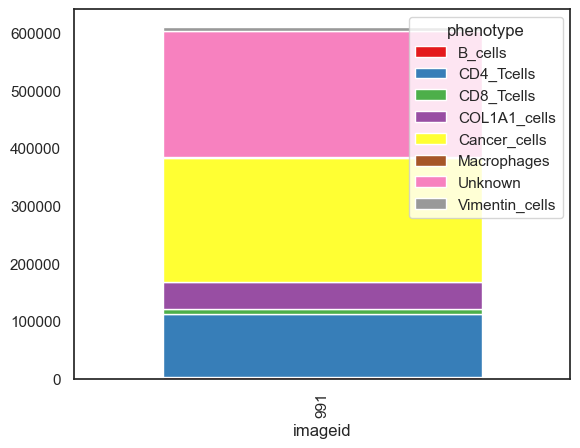

In [54]:
sm.pl.stacked_barplot (adata_pheno,
                       y_axis='phenotype',
                       method='absolute')

In [44]:
list_of_markers = ['mean_Vimentin', 'mean_CD20', 'mean_panCK', 'mean_CD3e', 'mean_CD8', "mean_Ki67", 'mean_CD68', "mean_COL1A1"]

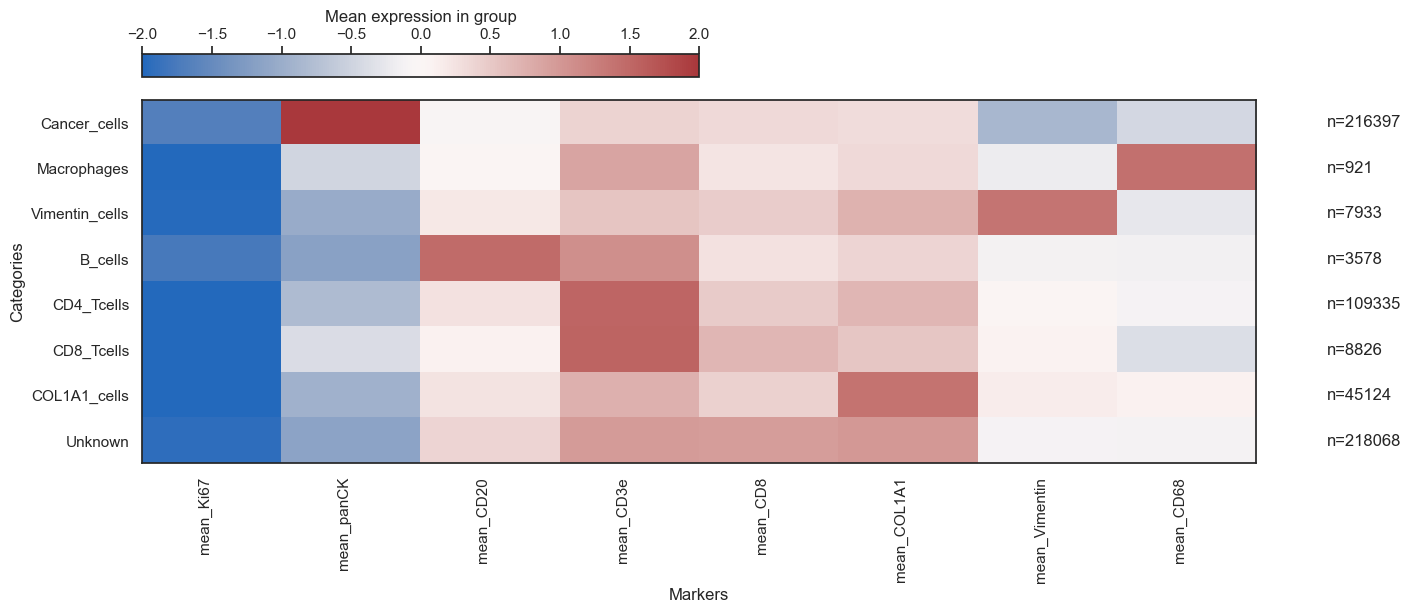

In [ ]:
sm.pl.heatmap(adata_pheno, 
            groupBy='phenotype',
            subsetMarkers=list_of_markers,
            standardScale='column', 
            figsize=(14,6), 
            showPrevalence=True, vmin=-2, vmax=2)

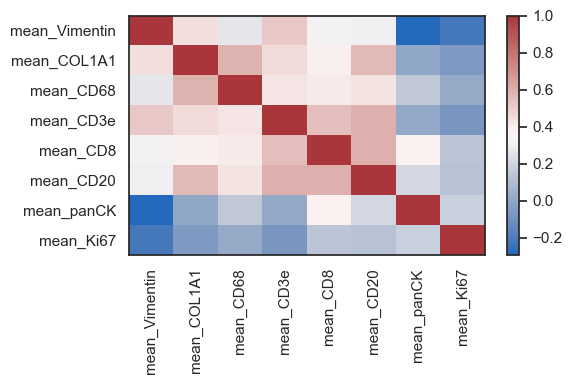

In [57]:
sm.pl.markerCorrelation(adata_pheno, figsize=(6,4))